## **🗑️🚮Project: Sustainable Waste Detection Management System🚀📚**

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import zipfile
import shutil
import os
import random
import cv2
import glob
import pathlib
import datetime
import matplotlib.image as mpimg
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.activations import relu,sigmoid, softmax
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Project: Waste Classification

/content/drive/MyDrive/Project: Waste Classification


In [ ]:
# Checking if GPU is available or not
if tf.config.list_physical_devices('GPU'):
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


### **1. Unzipping the data File**

In [ ]:
def unzip_data(filename):
  """
  This function unzips filename into the current working directory.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

unzip_data("/content/drive/MyDrive/Project: Waste Classification/realwaste.zip")

### **2. Data Analysis**

In [ ]:
classes_dir = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWaste"
classes_path = pathlib.Path(classes_dir)
class_names = np.array(sorted([item.name for item in classes_path.glob("*")]))
class_names.tolist()

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [ ]:
def count_jpg_files(root_dir):
    materials_count = []

    for dirpath, _, filenames in os.walk(root_dir):
        material_count = 0

        for filename in filenames:
            if filename.lower().endswith('.jpg'):
                material_count += 1
        materials_count.append(material_count)

    materials_count.pop(0)
    return materials_count

root_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWaste"
materials_count = count_jpg_files(root_directory)
print("Counts of jpg files in each subdirectory:", materials_count)

Counts of jpg files in each subdirectory: [461, 411, 420, 790, 495, 500, 921, 318, 436]


In [ ]:
features_dict = {"Material": class_names, "Count": materials_count}
df = pd.DataFrame(features_dict)
df

Material  Count
0            Cardboard    461
1        Food Organics    411
2                Glass    420
3                Metal    790
4  Miscellaneous Trash    495
5                Paper    500
6              Plastic    921
7        Textile Trash    318
8           Vegetation    436

### **3. Data Visualization**

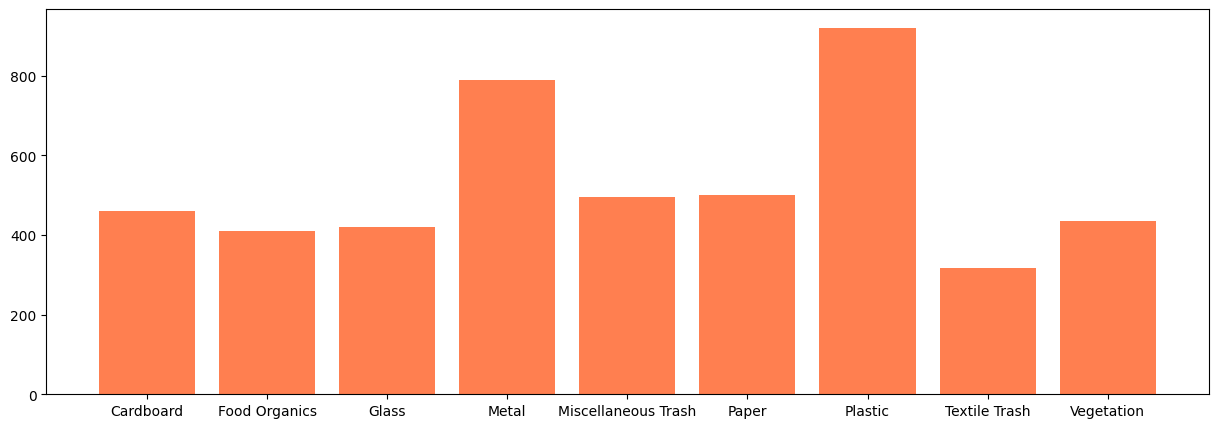

In [ ]:
# Plot to visualize the distribution of different cell types
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(df["Material"], df["Count"], color='coral');

In [ ]:
labels = class_names
values = materials_count
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [ ]:
def view_random_image(target_dir):
  target_folder = target_dir

  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img

['Food Organics_244.jpg']
Image shape: (524, 524, 3)


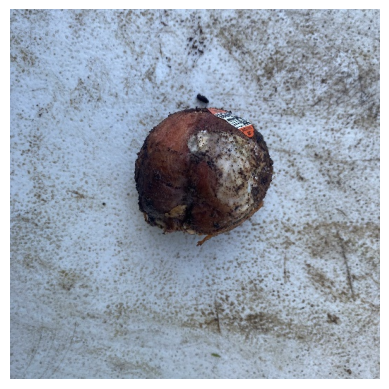

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWaste/Food Organics")

Image Shape: (524, 524, 3)
Image Datatype: uint8
Class Name: Cardboard


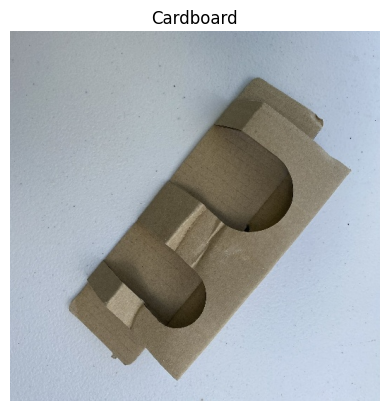

In [ ]:
def print_sample_info(train_dir):
    """
    Print image shape, datatype, and class name for one sample from the training dataset.

    Parameters:
    - train_dir (str): Path to the directory containing subdirectories of training images.
    """
    subdirectories = sorted(os.listdir(train_dir))
    class_name = subdirectories[0]

    subdir_path = os.path.join(train_dir, class_name)
    image_name = os.listdir(subdir_path)[0]
    image_path = os.path.join(subdir_path, image_name)

    image = mpimg.imread(image_path)
    image_shape = image.shape
    image_dtype = image.dtype

    print("Image Shape:", image_shape)
    print("Image Datatype:", image_dtype)
    print("Class Name:", class_name)

    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
    plt.show()

# Example usage:
train_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/train"
print_sample_info(train_directory)


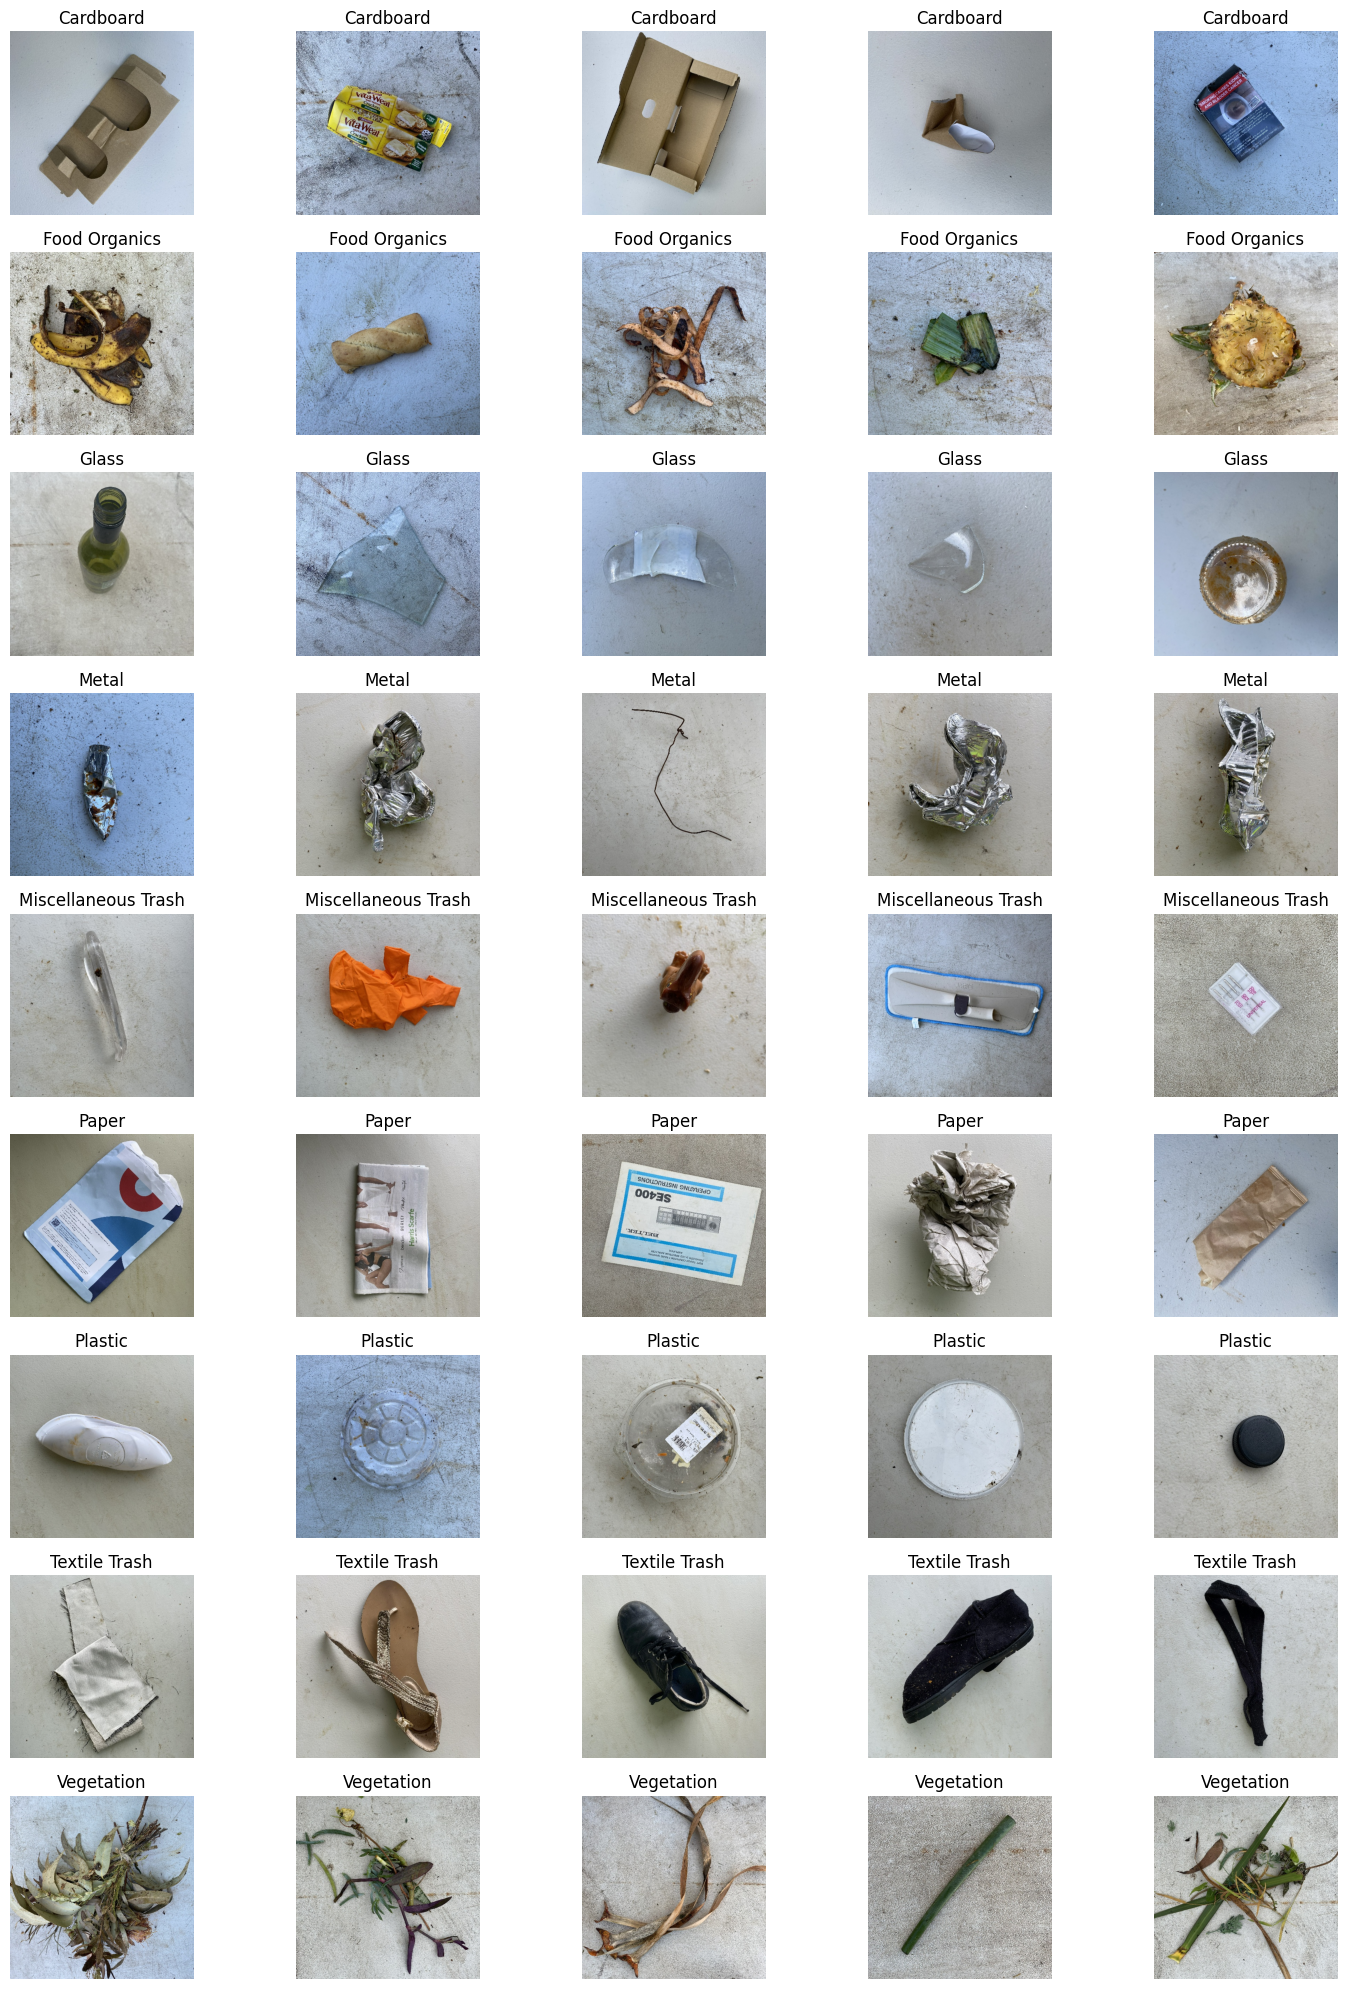

In [ ]:
def plot_images_from_subdirectories(train_dir, num_images=5):
    subdirectories = sorted(os.listdir(train_dir))
    num_subdirectories = len(subdirectories)

    plt.figure(figsize=(15, 20))

    for i, subdir in enumerate(subdirectories, start=1):
        subdir_path = os.path.join(train_dir, subdir)
        images = os.listdir(subdir_path)[:num_images]

        for j, image_name in enumerate(images, start=1):
            image_path = os.path.join(subdir_path, image_name)
            image = mpimg.imread(image_path)

            plt.subplot(num_subdirectories, num_images, (i-1)*num_images + j)
            plt.imshow(image)
            plt.title(subdir)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
train_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/train"
plot_images_from_subdirectories(train_directory)

In [ ]:
shutil.rmtree('/content/drive/MyDrive/Project: Waste Classification/customImages/.ipynb_checkpoints', ignore_errors=True)

### **4. Splitting data into train, valid and test data directories**

In [ ]:
def split_data_into_train_val_test(data_dir, train_dir, val_dir, test_dir, val_split=0.1, test_split=0.1):
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    for root, dirs, files in os.walk(data_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            files = os.listdir(subdir_path)
            random.shuffle(files)

            num_files = len(files)
            val_size = int(num_files * val_split)
            test_size = int(num_files * test_split)
            train_size = num_files - val_size - test_size

            train_files = files[:train_size]
            val_files = files[train_size:train_size + val_size]
            test_files = files[train_size + val_size:]

            for filename in train_files:
                src = os.path.join(subdir_path, filename)
                dest = os.path.join(train_dir, subdir)
                if not os.path.exists(dest):
                    os.makedirs(dest)
                shutil.copy(src, dest)

            for filename in val_files:
                src = os.path.join(subdir_path, filename)
                dest = os.path.join(val_dir, subdir)
                if not os.path.exists(dest):
                    os.makedirs(dest)
                shutil.copy(src, dest)

            for filename in test_files:
                src = os.path.join(subdir_path, filename)
                dest = os.path.join(test_dir, subdir)
                if not os.path.exists(dest):
                    os.makedirs(dest)
                shutil.copy(src, dest)

    print("Data distribution complete.")

data_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWaste"
train_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/train"
val_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/val"
test_directory = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/test"

split_data_into_train_val_test(data_directory, train_directory, val_directory, test_directory)

Data distribution complete.


### **5. Fetching train, val and test datasets from their respective directories**

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Setup paths to our data directories
train_dir = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/train"
val_dir = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/val"
test_dir = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/test"

# Create a TensorFlow dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    train_dir,
                                                                    batch_size=32,
                                                                    image_size=(224, 224),
                                                                    seed=42,
                                                                    label_mode='categorical')

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    val_dir,
                                                                    batch_size=32,
                                                                    image_size=(224, 224),
                                                                    seed=42,
                                                                    label_mode='categorical')

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    test_dir,
                                                                    batch_size=32,
                                                                    image_size=(224, 224),
                                                                    seed=42,
                                                                    label_mode='categorical')

Found 3806 files belonging to 9 classes.
Found 473 files belonging to 9 classes.
Found 473 files belonging to 9 classes.


### **6. Applying Prefetching in order to speed up the training process**

In [ ]:
train_data = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### **7. Implementing Data Augmentation to increase `Robustness` of the model**

In [ ]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)
], name="data_augmentation")

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.axis("off")

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)
  plt.axis("off")

['Vegetation_416.jpg']
Image shape: (524, 524, 3)


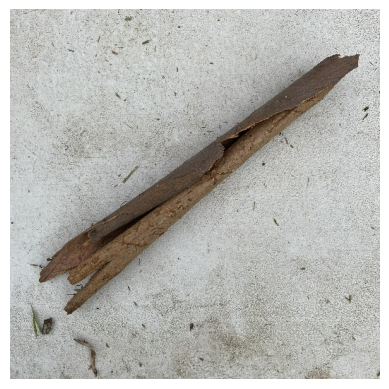

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWaste/Vegetation")

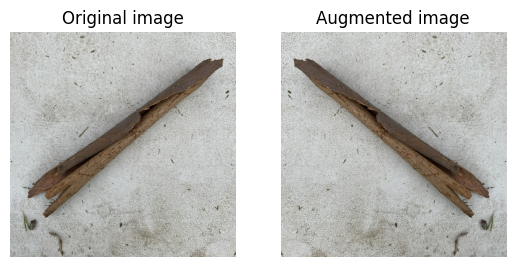

In [ ]:
flipped = tf.image.flip_left_right(img)
visualize(img, flipped)

In [ ]:
# Add the image to a batch.
img = tf.cast(tf.expand_dims(img, 0), tf.float32)

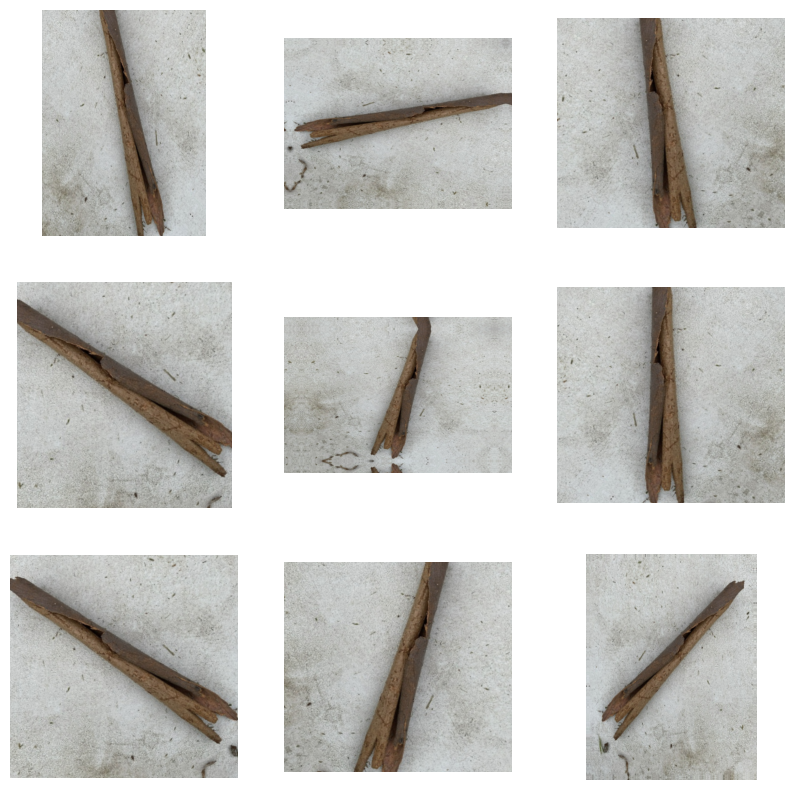

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(img)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255.0)
  plt.axis('off')

### **8. Setting up the base Model and choosing the Model Architecture**

In order to choose the correct pre-trained model, different model architectures have been used:-

        Architecture        Accuracy
        MobileNetV2    -    70.12%
        DenseNet       -    80.34%
        EfficientNetB4 -    82.24%
        EfficientNetB0 -    90.91%

In [ ]:
# Setup input shape and base mode, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# Make a model using the inputs and outputs
model = tf.keras.Model(inputs, outputs)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

### **9. Attaching callbacks to monitor training progress**

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Set EarlyStopping callback to stop training if model's val accuracy doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "/content/drive/MyDrive/Project: Waste Classification/realwaste-main/model_checkpoints/cp.ckpt"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       monitor="val_loss",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0)

### **10. Model Compiling**

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

### **11. Model Training with Feature Extraction**

In [ ]:
# Fit the model
history_feature_extraction = model.fit(x=train_data,
                                       epochs=100,
                                       steps_per_epoch=len(train_data),
                                       validation_data=val_data,
                                       callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Project: Waste Classification/realwaste-main",
                                                                              experiment_name="Real_Waste_with_Feature_Extraction"),
                                                  model_checkpoints,
                                                  early_stopping])

In [ ]:
# Evaluate on the test data
results_of_feature_extraction = model.evaluate(test_data)
results_of_feature_extraction

15/15 [==============================] - 4s 153ms/step - loss: 0.5191 - accuracy: 0.8055


[0.519107460975647, 0.8054968118667603]

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1792)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dropout_11 (Dropout)        (None, 1792)              0         
                                                                 
 dense_12 (Dense)            (None, 9)                 16137     
                                                          

#### **Plotting the plots**

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

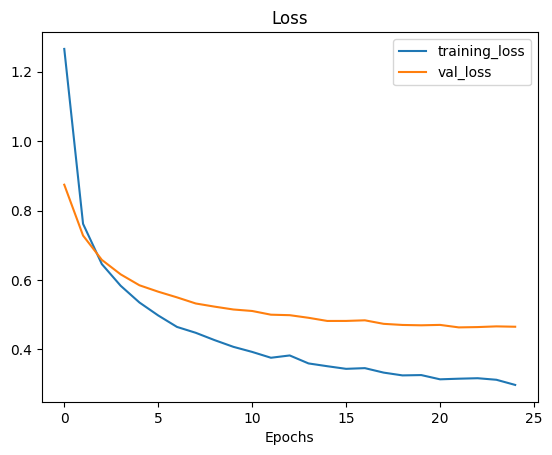

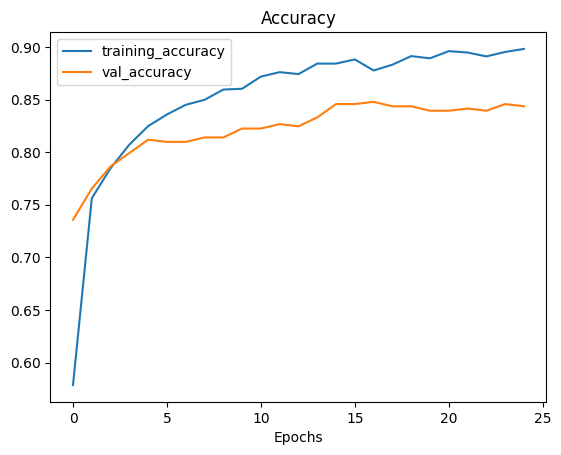

In [ ]:
plot_loss_curves(history_feature_extraction)

#### **Saving the Feature Extraction Model**

In [ ]:
model.save("/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWasteFeatureExtraction.hdf5")

### **12. Time to Implement Fine Tuning😋**

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-10]:
  layer.trainable = False

Number of layers in the base model:  475


#### **Model Compiling**

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

#### **Model Training with Fine Tuning**

In [ ]:
# Fit the model
history_fine_tuning = model.fit(x=train_data,
                                epochs=100,
                                steps_per_epoch=len(train_data),
                                initial_epoch=history_feature_extraction.epoch[-1],
                                validation_data=val_data,
                                callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Project: Waste Classification/realwaste-main",
                                                                              experiment_name="Real_Waste_with_Fine_Tuning"),
                                                  model_checkpoints,
                                                  early_stopping])

Saving TensorBoard log files to: /content/drive/MyDrive/Project: Waste Classification/realwaste-main/Real_Waste_with_Fine_Tuning/20240326-235657
Epoch 25/100
119/119 [==============================] - 49s 269ms/step - loss: 0.3065 - accuracy: 0.8954 - val_loss: 0.4555 - val_accuracy: 0.8541
Epoch 26/100
119/119 [==============================] - 28s 230ms/step - loss: 0.2229 - accuracy: 0.9196 - val_loss: 0.4468 - val_accuracy: 0.8478
Epoch 27/100
119/119 [==============================] - 28s 227ms/step - loss: 0.1708 - accuracy: 0.9435 - val_loss: 0.4423 - val_accuracy: 0.8393
Epoch 28/100
119/119 [==============================] - 28s 227ms/step - loss: 0.1310 - accuracy: 0.9566 - val_loss: 0.4326 - val_accuracy: 0.8626
Epoch 29/100
119/119 [==============================] - 27s 209ms/step - loss: 0.1019 - accuracy: 0.9700 - val_loss: 0.4651 - val_accuracy: 0.8541
Epoch 30/100
119/119 [==============================] - 28s 219ms/step - loss: 0.0720 - accuracy: 0.9795 - val_loss: 0.4

In [ ]:
results_of_fine_tuning = model.evaluate(test_data);
results_of_fine_tuning

15/15 [==============================] - 3s 149ms/step - loss: 0.5847 - accuracy: 0.8224


[0.5847195982933044, 0.8224101662635803]

#### **Plotting the plots**

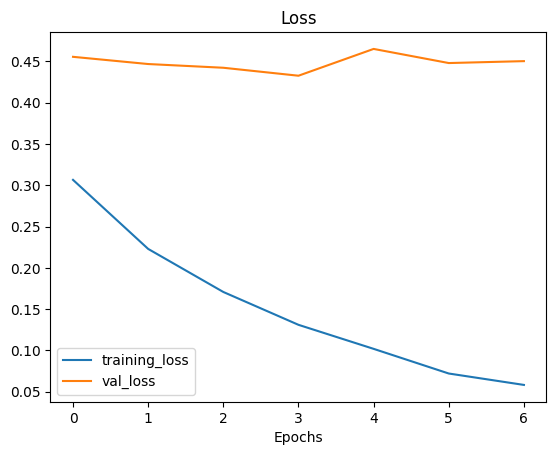

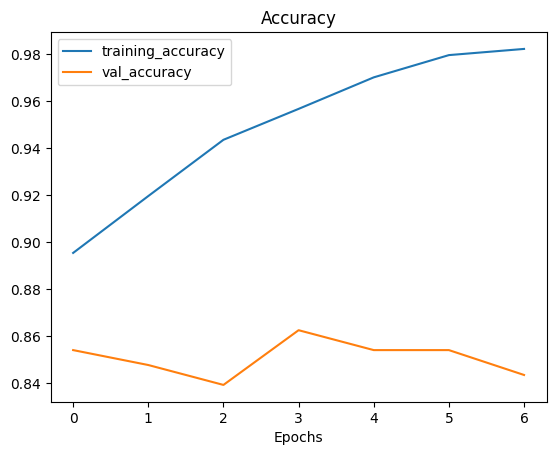

In [ ]:
plot_loss_curves(history_fine_tuning)

#### **Saving the Fine Tuning Model**

In [ ]:
model.save("/content/drive/MyDrive/Project: Waste Classification/realwaste-main/RealWasteFineTuning.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



### **13. Let's test our model on Custom images🧪**

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)

  img = tf.io.decode_image(img, channels=3)

  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

In [ ]:
cd /content/drive/MyDrive/Project: Waste Classification

/content/drive/MyDrive/Project: Waste Classification


#### **Store the custom Images filepaths**

In [ ]:
# Get custom images filepaths
customImages = ["customImages/" + img_path for img_path in os.listdir("customImages")]
customImages

['customImages/cardboard.jpeg',
 'customImages/pen.jpeg',
 'customImages/plastic.jpeg',
 'customImages/metal.jpeg',
 'customImages/food.jpeg',
 'customImages/glass.jpeg',
 'customImages/paper.jpg',
 'customImages/textile.jpg']

#### **Make Prediction on  Custom Images**

1/1 [==============================] - 0s 32ms/step


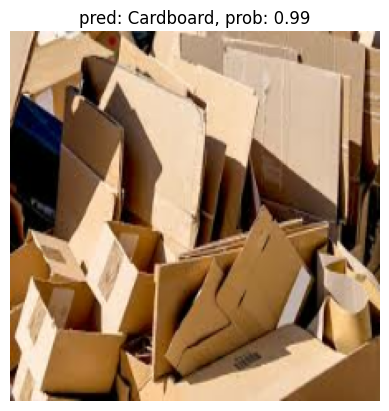

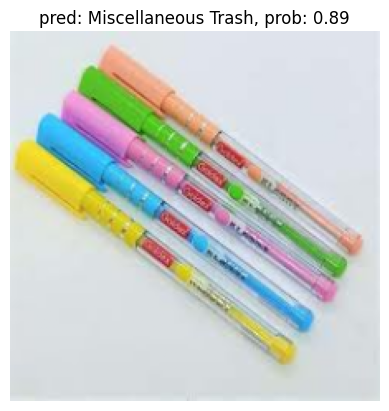

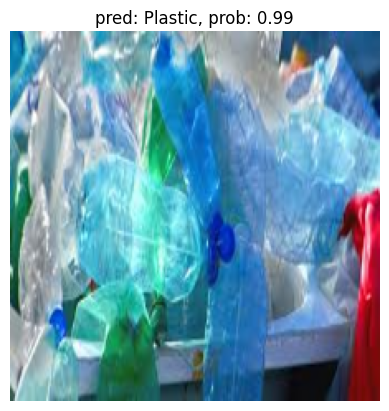

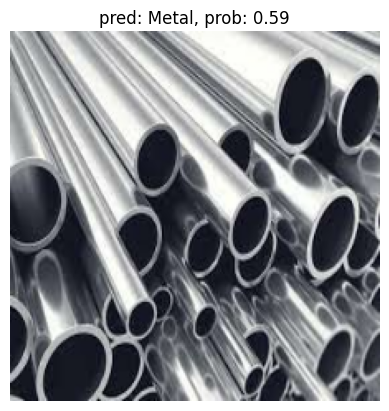

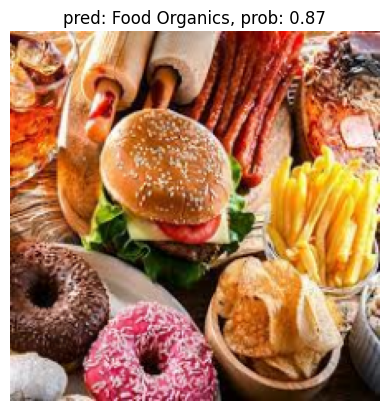

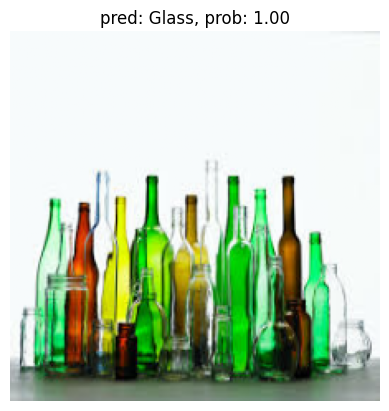

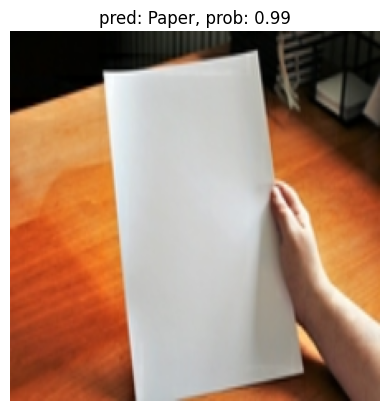

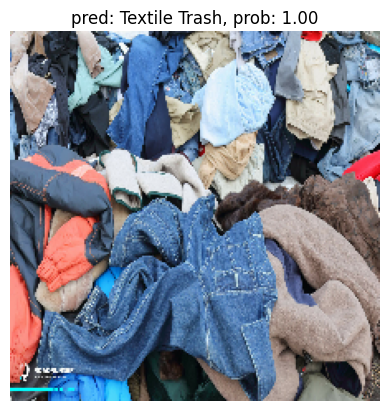

In [ ]:
# Make predictions on custom images
for img in customImages:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)